# Estimation of impurity measurements

Van a ser estimados para ejemplos controlados medidas de impureza como GINY y Entropy para ayudar en el split mas optimo de una variable (numerica, categorical, ordinal) en dos o mas categorias.


### References

- [Gini Index vs Information Entropy (toward data science)](https://towardsdatascience.com/gini-index-vs-information-entropy-7a7e4fed3fcb)
- [Gini Impurity Measure – a simple explanation using python](https://www.bogotobogo.com/python/scikit-learn/scikt_machine_learning_Decision_Tree_Learning_Informatioin_Gain_IG_Impurity_Entropy_Gini_Classification_Error.php)

In [1]:
!pip install unidip

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
from tools import *

## functions

In [9]:
## Estimate probability of a categorical/ordinal variable
def estimate_probability_non_numerical(df:pd.DataFrame, colname:str)->pd.DataFrame:
    """
    Estimate probability values of a categorical/ordinal variable.
    df -- df who include the variable to be used.
    colname -- variable name of data to be used.
    return -- df of categories and their respective probabilities.
    """
    # validate if colname in df
    assert colname in df.columns.tolist(), f'"{colname}" is required.'
    # validate if too much categories
    cats = list(df[colname].dropna().unique())
    assert len(cats) < 50, f'"{colname}" has too much categories.'
    # create dictionary of probability values per categories        
    dfprob = df[[colname]].dropna().groupby(colname)[[colname]].count() / len(df[[colname]].dropna())
    # rename
    dfprob.rename(columns = {colname: 'probability'}, inplace = True)
    # return 
    return dfprob.reset_index()

# DATA

### create Gaussian distribution data (Unimodal, Multimodal)

<AxesSubplot:ylabel='Frequency'>

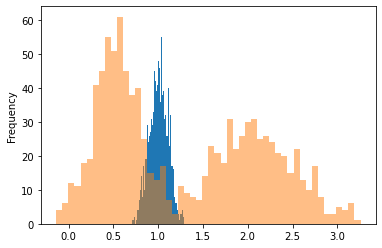

In [3]:
## Unimodal
mu, sigma = 1, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
datagauss = pd.DataFrame({'uni': s})
## Multimodal
mu1, sigma1 = 2, 0.5 # mean and standard deviation
s1 = np.random.normal(mu1, sigma1, 500)
s = np.concatenate((s1, 0.5*s1 - .5))
datagauss['multi'] = s
## plot
datagauss.uni.plot(kind = 'hist', bins = 50)
datagauss.multi.plot(kind = 'hist', bins = 50, alpha = .5)

### data gauss unimodal

stat=0.189, p=0.000
Probably is not Uniform
stat=0.008, p=0.985
Probably unimodal
Number of modals = 1


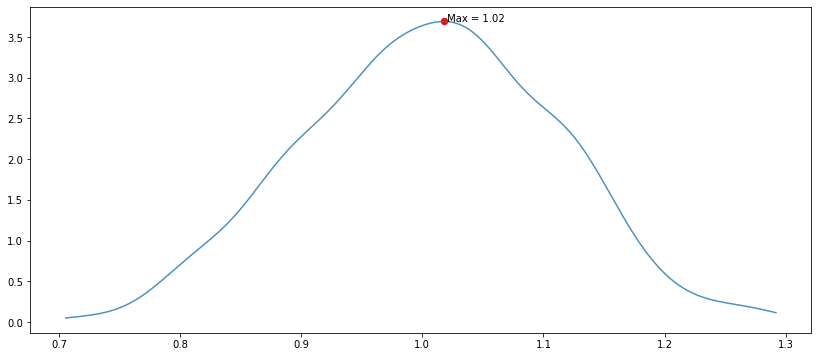

In [4]:
# collect data
v = datagauss['uni'].values
# test uniform
test_uniform_num(v)
# dip test
test_dip(v, alpha = .05)
# get pdf and local maximuns
pdf_kde, x, local_max = get_pdf_1d(v)
# display results
print(f'Number of modals = {len(local_max)}')
# plot
plot_pdf_1d(v)

### data gauss multimodal

stat=0.161, p=0.000
Probably is not Uniform
stat=0.042, p=0.001
Probably not unimodal.
Number of modals = 2


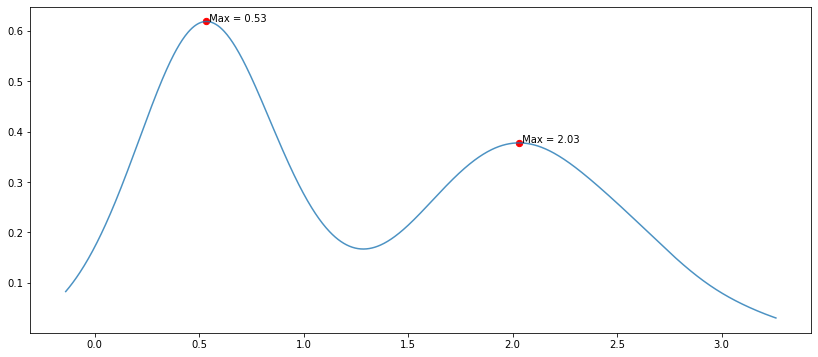

In [5]:
# collect data
v = datagauss['multi'].values
# test uniform
test_uniform_num(v)
# dip test
test_dip(v, alpha = .05)
# get pdf and local maximuns
pdf_kde, x, local_max = get_pdf_1d(v)
# display results
print(f'Number of modals = {len(local_max)}')
# plot
plot_pdf_1d(v)

### MODALS CLUSTERIZATION

- https://cmdlinetips.com/2021/03/gaussian-mixture-models-with-scikit-learn-in-python/amp/
- https://pypi.org/project/unidip/

### data gauss multimodal

stat=0.182, p=0.000
Probably is not Uniform
stat=0.042, p=0.001
Probably not unimodal.
number of modals = 2
cluster means: [array([0.54018614]), array([2.08001112])]


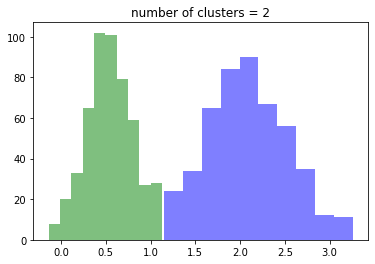

In [6]:
# collect data
v = datagauss['multi'].values
# test uniform
test_uniform_num(v)
# dip test
test_dip(v, alpha = .05)
# get clusters
labels = get_1d_clusters_kde(v)
# plot
plot_1d_clusters_kde(v, labels)

# GINI index

In [103]:
# GINI index estimation
def GINI(p:np.array)->float:
    """
    GINI index estimation.
    p -- array of probabilities of all classes.
    return -- GINI index.
    """
    # validate probabilities
    if np.sum(p) != 1:
        print("[warning] probabilities don't sum 1.")
    # gini index for one category
    i_gini = lambda ip: ip*(1 - ip)
    # sum gini index for all categories and return
    return np.sum(i_gini(p))

### split of data by KDE (2 clusters)

Para esta clusterizacion que parece muy buena, el GINI index deberia ser cerca de `0.5`.

In [104]:
# collect data
v = datagauss['multi'].values
# estimate clusters by kde
labels = get_1d_clusters_kde(v, verbose = False)
# store in df
df = pd.DataFrame({'variable':v, 'cluster':labels})
# get probability table
dfprob = estimate_probability_non_numerical(df, 'cluster')
# collect probability values of all categories
p = dfprob.probability.values
# estimate gini index
gini_index = GINI(p)
print(f'GINI index = {gini_index}')

GINI index = 0.499032


## split optimization with GINI index (2 clusters)

In [105]:
# collect data
df = datagauss[['multi']].copy()
v = df.multi.values
# get possible splitting points
x = np.linspace(v.min(),v.max(), 1000)[1:-1]
# initialize
gini_results = list()
# loop of splittings points
for ix in x:
    # inpute clusters
    fcluster = lambda iv: 1 if iv < ix else 2
    df['cluster'] = df['multi'].apply(fcluster)
    # get probability table
    idfprob = estimate_probability_non_numerical(df, 'cluster')
    # collect probability values of all categories
    ip = idfprob.probability.values
    # estimate gini index
    igini_index = GINI(ip)
    #print(ix, f'GINI index = {igini_index}')
    # append
    gini_results.append(igini_index)
# list to array
gini_results = np.array(gini_results)
# indexes of maximum gini index
i_gini_max = np.where(gini_results == np.max(gini_results))[0]
# maximum gini index
gini_max = np.mean(gini_results[i_gini_max])
print(f'Maximum GINI index = {gini_max}')
# optimal splitting point
optimal_x = np.mean(x[i_gini_max])
print(f'Optimal Splitting Point = {optimal_x}')

Maximum GINI index = 0.499998
Optimal Splitting Point = 1.0194400749005987


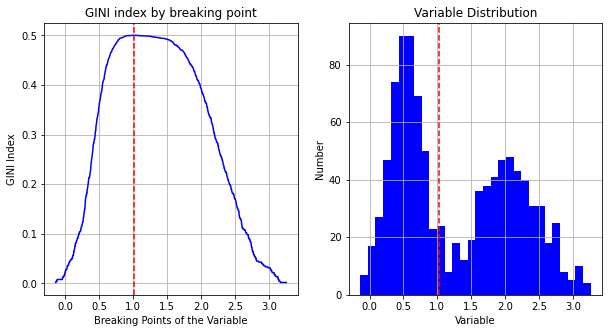

In [106]:
# plot gini index in optimization process
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10,5))

ax1 = plt.subplot2grid((1,2),(0,0)) 
ax1.plot(x, gini_results, color = 'blue')
ax1.set_xlabel("Breaking Points of the Variable")
ax1.set_ylabel("GINI Index")
ax1.xaxis.grid(True)
ax1.yaxis.grid(True)
ax1.set_title("GINI index by breaking point")
ax1.axvline(optimal_x, color='red', linestyle='--')

ax2 = plt.subplot2grid((1,2),(0,1)) 
ax2.hist(v, color = 'blue', bins = 30)
ax2.set_xlabel("Variable")
ax2.set_ylabel("Number")
ax2.xaxis.grid(True)
ax2.yaxis.grid(True)
ax2.set_title("Variable Distribution")
ax2.axvline(optimal_x, color='red', linestyle='--')
plt.show()

# INFORMATION ENTROPY

In [107]:
# Information Entropy
def ENTROPY(p:np.array)->float:
    """
    Information Entropy.
    p -- array of probabilities of all classes.
    return -- Information Entropy.
    """
    # validate probabilities
    if np.sum(p) != 1:
        print("[warning] probabilities don't sum 1.")
    # entropy for one category
    i_entropy = lambda ip: ip*np.log2(ip)
    # sum entropy for all categories and return
    return -np.sum(i_entropy(p))

### split of data by KDE (2 clusters)

Para esta clusterizacion que parece muy buena, la Entropia deberia ser cerca de `1.0`.

In [108]:
# collect data
v = datagauss['multi'].values
# estimate clusters by kde
labels = get_1d_clusters_kde(v, verbose = False)
# store in df
df = pd.DataFrame({'variable':v, 'cluster':labels})
# get probability table
dfprob = estimate_probability_non_numerical(df, 'cluster')
# collect probability values of all categories
p = dfprob.probability.values
# estimate entropy
entropy = ENTROPY(p)
print(f'Information Entropy = {entropy}')

Information Entropy = 0.9986030202378096


## split optimization with Entropy (2 clusters)

In [109]:
# collect data
df = datagauss[['multi']].copy()
v = df.multi.values
# get possible splitting points
x = np.linspace(v.min(),v.max(), 1000)[1:-1]
# initialize
entropy_results = list()
# loop of splittings points
for ix in x:
    # inpute clusters
    fcluster = lambda iv: 1 if iv < ix else 2
    df['cluster'] = df['multi'].apply(fcluster)
    # get probability table
    idfprob = estimate_probability_non_numerical(df, 'cluster')
    # collect probability values of all categories
    ip = idfprob.probability.values
    # estimate entropy
    ientropy = ENTROPY(ip)
    # append
    entropy_results.append(ientropy)
# list to array
entropy_results = np.array(entropy_results)
# indexes of maximum entropy
i_entropy_max = np.where(entropy_results == np.max(entropy_results))[0]
# maximum entropy
entropy_max = np.mean(entropy_results[i_entropy_max])
print(f'Maximum Entropy = {entropy_max}')
# optimal splitting point
optimal_x = np.mean(x[i_entropy_max])
print(f'Optimal Splitting Point = {optimal_x}')

Maximum Entropy = 0.9999971146079947
Optimal Splitting Point = 1.0194400749005987


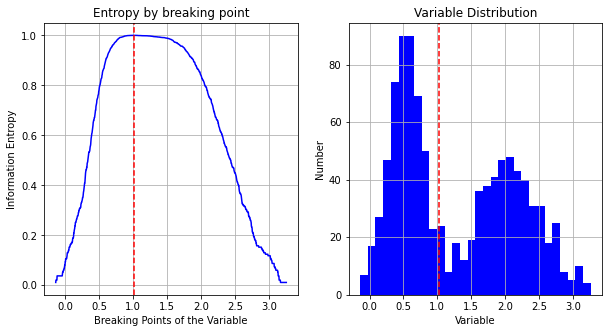

In [110]:
# plot entropy in optimization process
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10,5))

ax1 = plt.subplot2grid((1,2),(0,0)) 
ax1.plot(x, entropy_results, color = 'blue')
ax1.set_xlabel("Breaking Points of the Variable")
ax1.set_ylabel("Information Entropy")
ax1.xaxis.grid(True)
ax1.yaxis.grid(True)
ax1.set_title("Entropy by breaking point")
ax1.axvline(optimal_x, color='red', linestyle='--')

ax2 = plt.subplot2grid((1,2),(0,1)) 
ax2.hist(v, color = 'blue', bins = 30)
ax2.set_xlabel("Variable")
ax2.set_ylabel("Number")
ax2.xaxis.grid(True)
ax2.yaxis.grid(True)
ax2.set_title("Variable Distribution")
ax2.axvline(optimal_x, color='red', linestyle='--')
plt.show()

# INFORMATION GAIN (for GINI or Entropy)

In [116]:
## Estimate Information Gain for Entropy or GINI index
def INFORMATION_GAIN(p:np.array, impurity_metric:'function' = ENTROPY)->float:
    """
    Estimate Information Gain for Entropy or GINI index.
    p -- array of probabilities.
    impurity_metric -- function for impurity metric estimation (default, ENTROPY).
    return -- information gain value.
    """
    return (impurity_metric(p) - np.sum([ip * impurity_metric(np.array([ip])) for ip in p])) * 100

### split of data by KDE (2 clusters)

In [115]:
# collect data
v = datagauss['multi'].values
# estimate clusters by kde
labels = get_1d_clusters_kde(v, verbose = False)
# store in df
df = pd.DataFrame({'variable':v, 'cluster':labels})
# get probability table
dfprob = estimate_probability_non_numerical(df, 'cluster')
# collect probability values of all categories
p = dfprob.probability.values
# estimate information gain by entropy
gain_entropy = INFORMATION_GAIN(p)
print(f'Information Gain by Entropy = {gain_entropy} %')
# estimate information gain by entropy
gain_gini = INFORMATION_GAIN(p, impurity_metric = GINI)
print(f'Information Gain by GINI = {gain_gini} %')

[warning] probabilities don't sum 1.
[warning] probabilities don't sum 1.
Information Gain by Entropy = 49.97295880432348 %
[warning] probabilities don't sum 1.
[warning] probabilities don't sum 1.
Information Gain by GINI = 24.951599999999996 %
